In [14]:
# Bibliotecas
import sys, pandas as pd, numpy as np
import plotly.express as px
import seaborn as sns, numpy as np, os

from env.RiverProblem import RiverProblem
from rl_utils.VizTools import VizTools

# Modelos
from models.ValueIteration import ValueIteration
from models.PolicyIteration import PolicyIteration
from models.RS_PolicyIteration import RS_PolicyIteration
from models.PieceLinear_RSPI import PieceLinear_RSPI

from evaluation.AverageCosts import AverageCosts

sys.path.append('../')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experimentos - 1S2023

|Data|Descritivo|
|--|--|
|03-2023|Primeiros experimentos com confecção de artigo|

---

## Exponential

2013 MICAI: Shortest Stochastic Path with Risk Sensitive Evaluation \
ou 2016 BRACIS: Extreme Risk Averse Policy for Goal-Directed Risk-Sensitive MDP

## Piecewise Linear

2020 MICAI: Risk-Sensitive Piecewise-Linear Policy Iteration for SSP-MDP

### To-do

**Conjunto de Experimentos + Artigo**

Prazo Rápido

- Medidas de Risco - exponencial e piecewise;
    - (?) quão próximos estão em termos de fator de risco;
    - Um aumento no fator de risco, como influencia em cada medida (?);
    - Curva: K -> Lambda; Lambda -> K;
    - Faz diferença utilizar algum desses métodos (?)
    - Política ótima; performance;...
    - Como Fator de Desconto influencia (?)
    - Adicionar novas medidas + CVAR, por exemplo;
- Descrever formalmente a metodologia/problema;
- Escolher um problema - River Problem - Cachoeira volta ao inicio;
- Escolher vários cenários do Rio, por exemplo, e ver o comportamento da curva gerada.

Implementações: Eduardo, Willy...

In [2]:
def run_river_problem(river_flow, model_obj, epsilon=None, vl_lambda=None, discount_factor=None, 
                                     k=None, gamma=None, alpha=None, _log=False):
    transition_probabilities = rp.build_transition_probabilities(block_type, river_flow=river_flow)

    is_ok, dict_verification = rp._verify_sum_probabilities(transition_probabilities, block_type)
    if not is_ok: print(f'Soma das Probabilidades está válida? {is_ok}')
    
    if epsilon != None and discount_factor != None:
        rnp = model_obj(grid_size, goal_state, transition_probabilities, costs, 
                         num_actions=4, discount_factor=discount_factor, epsilon=epsilon)
    elif vl_lambda != None and discount_factor != None:
        rnp = model_obj(grid_size, goal_state, transition_probabilities, costs, vl_lambda,
                         num_actions=4, discount_factor=discount_factor)
    elif k != None and gamma != None and alpha != None:
        rnp = model_obj(grid_size, goal_state, transition_probabilities, costs, k, alpha, gamma,
                         num_actions=4)
    
    num_iterations, time = rnp.run_converge()
    if _log: print(f'Número de Iterações: {num_iterations}')
    if _log: print(f'Tempo de Execução: {time}s')
    
    return rnp

# Value Iteration

In [3]:
viz_tools = VizTools()

grid_size = (5, 20)
goal_state = (4, 0)
rp = RiverProblem(grid_size, goal_state, dead_end=False)

discount_factor = 0.95
epsilon = 0.001

costs = {0: 1, 1: 1, 2: 1, 3: 1}
block_type = rp.build_block_type()

Número de Iterações: 50
Tempo de Execução: 0.5945000648498535s


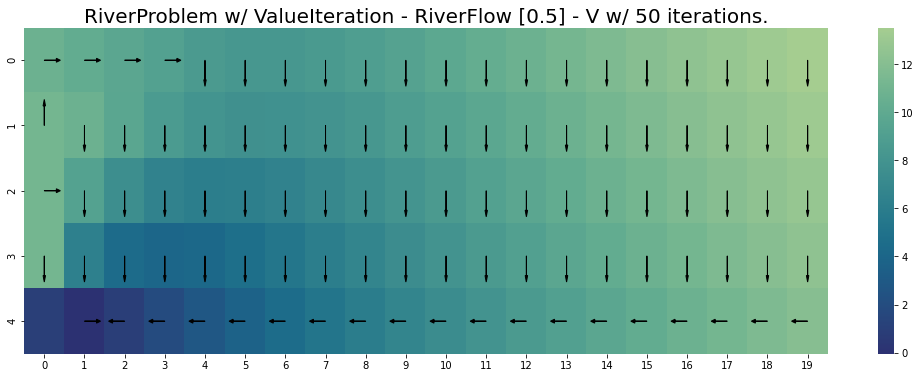

Número de Iterações: 25
Tempo de Execução: 0.29850077629089355s


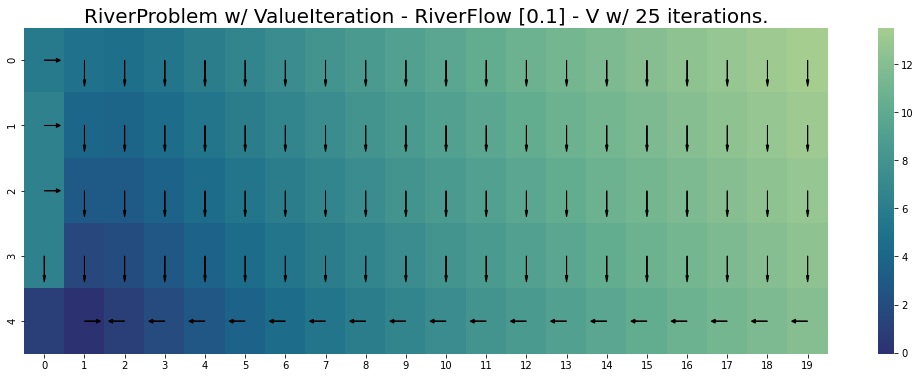

Número de Iterações: 64
Tempo de Execução: 0.7529993057250977s


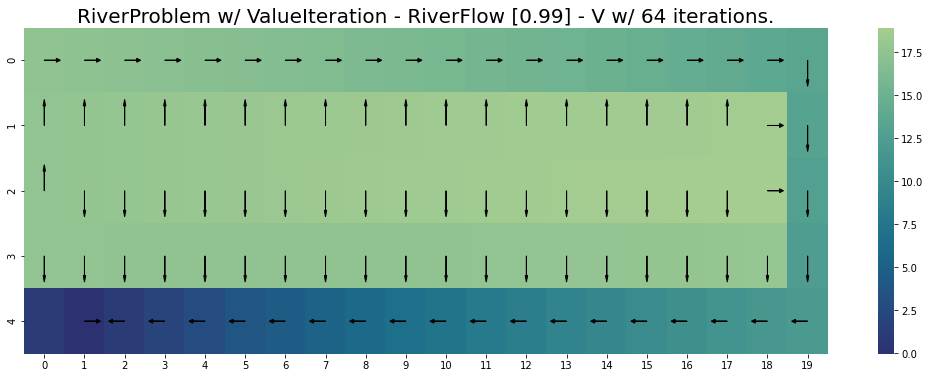

In [4]:
rnp = run_river_problem(river_flow=0.5, model_obj=ValueIteration, epsilon=epsilon, discount_factor=discount_factor)
rnp = run_river_problem(river_flow=0.1, model_obj=ValueIteration, epsilon=epsilon, discount_factor=discount_factor)
rnp = run_river_problem(river_flow=0.99, model_obj=ValueIteration, epsilon=epsilon, discount_factor=discount_factor)

# Policy Iteration

Definimos o algoritmo de Policy Iteration da seguinte forma:

1. Escolhe uma política $\pi_0$ arbitrária;
2. Define $i=0$ como a quantidade de iterações;
3. Para cada iteração, enquanto ($i=0$ ou $\pi_i \neq \pi_{i-1}$) faça: \
    3.1. Policy Evaluation: obtém o valor da política atual $\pi_i$ para cada $s \in S$ resolvendo o seguinte sistema de equações: \
    $$V^{(\pi_i)}(s)=r(s,\pi_i(s))+\sum_{s'\in S} T(s, \pi_i(s), s') V^{\pi_i}(s') \forall s \in S$$
    3.2. Policy Improvement: melhora a política atual realizando uma atualização para todo $s \in S$: \
    $$\pi_{i+1}(s)=\text{argmax}_{a \in A_s}[r(s,a)+\sum_{s'\in S} T(s, a, s') V^{\pi_i}(s')]$$

In [5]:
viz_tools = VizTools()

grid_size = (5, 20)
goal_state = (4, 0)
rp = RiverProblem(grid_size, goal_state, dead_end=False)

discount_factor = 0.99
epsilon = 0.001

costs = {0: 1, 1: 1, 2: 1, 3: 1}
block_type = rp.build_block_type()

Número de Iterações: 20
Tempo de Execução: 0.31149935722351074s


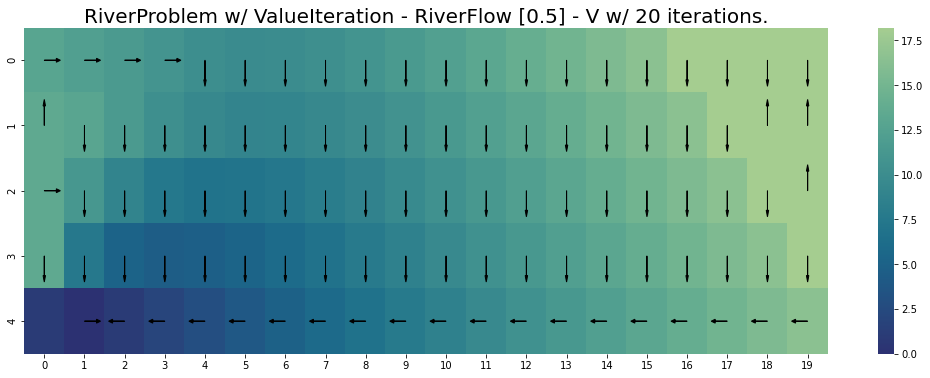

Número de Iterações: 20
Tempo de Execução: 0.30450010299682617s


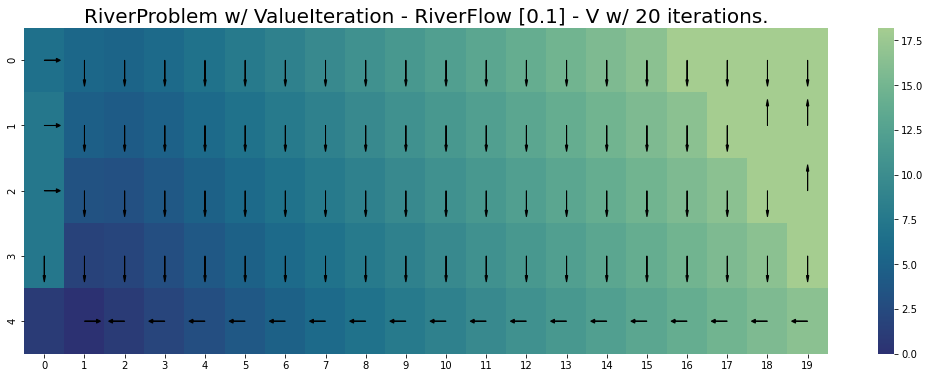

Número de Iterações: 21
Tempo de Execução: 0.3240034580230713s


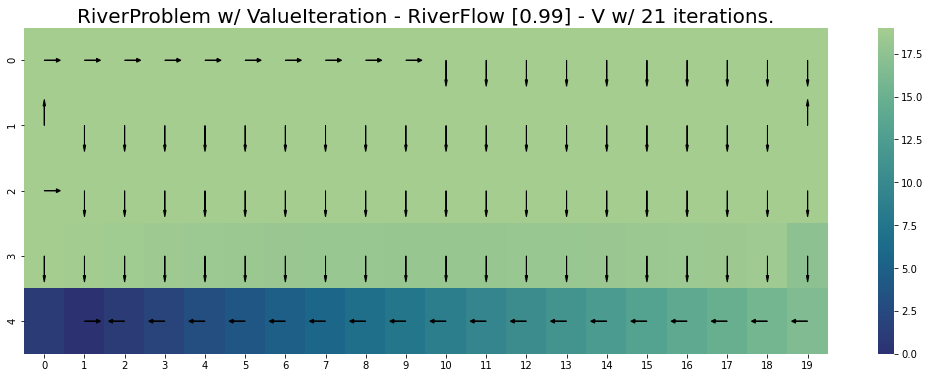

In [6]:
rp_pi = run_river_problem(river_flow=0.5, model_obj=PolicyIteration, epsilon=epsilon, discount_factor=discount_factor)
rp_pi = run_river_problem(river_flow=0.1, model_obj=PolicyIteration, epsilon=epsilon, discount_factor=discount_factor)
rp_pi = run_river_problem(river_flow=0.99, model_obj=PolicyIteration, epsilon=epsilon, discount_factor=discount_factor)

# RS-MDP

Definimos o algoritmo de Risk Sensitive MDP da seguinte forma:

1. Escolhe uma política $\pi_0$ arbitrária;
2. Define $i=0$ como a quantidade de iterações;
3. Para cada iteração, enquanto ($i=0$ ou $\pi_i \neq \pi_{i-1}$) faça: \
    3.1. Policy Evaluation: obtém o valor da política atual $\pi_i$ para cada $s \in S$ resolvendo o seguinte sistema de equações: \
    $$V^{\pi_i}(s_G)=-\text{sign}(\lambda)$$
    $$V^{(\pi_i)}(s)=\text{exp}(-\lambda r(s,\pi_i(s)))\sum_{s'\in S} T(s, \pi_i(s), s') V^{\pi_i}(s') \forall s \neq s_G \in S$$
    3.2. Policy Improvement: melhora a política atual realizando uma atualização para todo $s \in S$: \
    $$\pi_{i+1}(s)=\text{argmax}_{a \in A_s}[\text{exp}(-\lambda r(s,a))\sum_{s'\in S} T(s, a, s') V^{\pi_i}(s')]$$
    
    
When λ < 0 (risk prone) and the policy π is proper, then π is also λ-feasible. However, this is not guaranteed for all policies when λ > 0 (risk averse). Given a GD-RSMDP, no result exists on how to determine the set of λ > 0 such that exists a λ-feasible policy.


In [72]:
RSMDP = {}
viz_tools = VizTools()

grid_size = (5, 20)
goal_state = (4, 0)
rp = RiverProblem(grid_size, goal_state, dead_end=False)

costs = {0: 1, 1: 1, 2: 1, 3: 1}
block_type = rp.build_block_type()

range_river_flow = [rf/10 for rf in range(1, 10)]
range_lambda     = [1/10**(l) for l in range(0, 9)]
discount_factor  = 0.95

In [73]:
for river_flow in range_river_flow:
    for vl_lambda in range_lambda:
        RSMDP[(river_flow, vl_lambda, discount_factor)] = \
                                        run_river_problem(river_flow=river_flow, model_obj=RS_PolicyIteration, 
                                        discount_factor=discount_factor, vl_lambda=vl_lambda)

In [75]:
RSMDP.keys()

dict_keys([(0.1, 1.0, 0.95), (0.1, 0.1, 0.95), (0.1, 0.01, 0.95), (0.1, 0.001, 0.95), (0.1, 0.0001, 0.95), (0.1, 1e-05, 0.95), (0.1, 1e-06, 0.95), (0.1, 1e-07, 0.95), (0.1, 1e-08, 0.95), (0.2, 1.0, 0.95), (0.2, 0.1, 0.95), (0.2, 0.01, 0.95), (0.2, 0.001, 0.95), (0.2, 0.0001, 0.95), (0.2, 1e-05, 0.95), (0.2, 1e-06, 0.95), (0.2, 1e-07, 0.95), (0.2, 1e-08, 0.95), (0.3, 1.0, 0.95), (0.3, 0.1, 0.95), (0.3, 0.01, 0.95), (0.3, 0.001, 0.95), (0.3, 0.0001, 0.95), (0.3, 1e-05, 0.95), (0.3, 1e-06, 0.95), (0.3, 1e-07, 0.95), (0.3, 1e-08, 0.95), (0.4, 1.0, 0.95), (0.4, 0.1, 0.95), (0.4, 0.01, 0.95), (0.4, 0.001, 0.95), (0.4, 0.0001, 0.95), (0.4, 1e-05, 0.95), (0.4, 1e-06, 0.95), (0.4, 1e-07, 0.95), (0.4, 1e-08, 0.95), (0.5, 1.0, 0.95), (0.5, 0.1, 0.95), (0.5, 0.01, 0.95), (0.5, 0.001, 0.95), (0.5, 0.0001, 0.95), (0.5, 1e-05, 0.95), (0.5, 1e-06, 0.95), (0.5, 1e-07, 0.95), (0.5, 1e-08, 0.95), (0.6, 1.0, 0.95), (0.6, 0.1, 0.95), (0.6, 0.01, 0.95), (0.6, 0.001, 0.95), (0.6, 0.0001, 0.95), (0.6, 1e-05, 

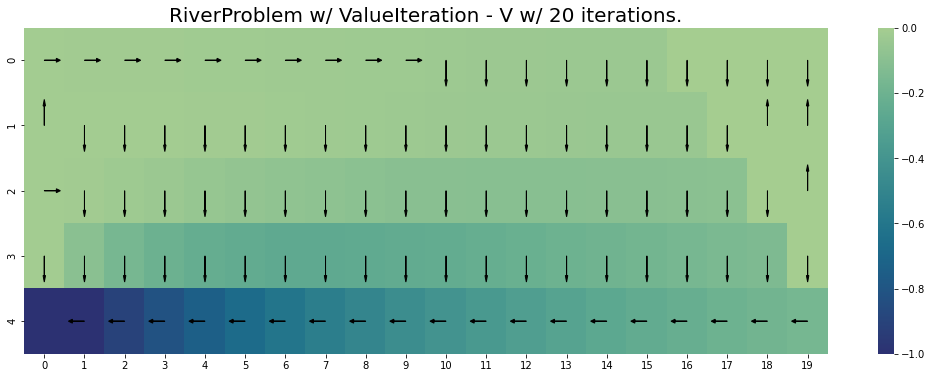

TypeError: __repr__ returned non-string (type NoneType)

In [79]:
RSMDP[((0.9, 1.0/10**1, 0.95))]

# PieceLinear - RSPI (Risk Sensitive Policy Iteration)

Define-se uma transformação por partes linear $X^{(k)}$ que depende de um parâmetro $x$ (diferença temporal) seja positiva ou não e um fator de risco $k$:

$$X^{(k)}(x)= \left\{ \begin{array} & (1-k)x & \text{, if x < 0,} \\ (1+k)x & \text{, otherwise.} \end{array} \right. $$

1. Escolhe uma política $\pi_0$ arbitrária;
2. Define $i=0$ como a quantidade de iterações;
3. Para cada iteração, enquanto ($i=0$ ou $\pi_i \neq \pi_{i-1}$) faça: \
    3.1. Policy Evaluation: obtém o valor da política atual $\pi_i$ para cada $s \in S$ resolvendo o seguinte sistema de equações: \
    $$
    O^{\pi}_{\alpha k}[V](s) = V(s) + \alpha \sum_{s'\in S} P(s'|s, \pi(s)) X^{(k)}(C(s,\pi(s),s')+\gamma V(s') - V(s))    
    $$
    3.2. Policy Improvement: melhora a política atual realizando uma atualização para todo $s \in S$: \
    $$
    \pi'(s)=\text{argmin}_{a\in A}\sum_{s'\in S} P(s'|s, \pi(s)) X^{(k)}(C(s,\pi(s),s')+\gamma V(s') - V^\pi_k(s))
    $$

In [3]:
RSPI = {}
viz_tools = VizTools()

grid_size = (5, 20)
goal_state = (4, 0)
rp = RiverProblem(grid_size, goal_state, dead_end=False)

costs = {0: 1, 1: 1, 2: 1, 3: 1}
block_type = rp.build_block_type()

range_river_flow = [rf/10 for rf in range(1, 10)]
range_k    = [v/10 for v in range(-10, 11)]
gamma      = 1
alpha      = 0.95

In [4]:
for river_flow in range_river_flow:
    for k in range_k:
        RSPI[(river_flow, k, gamma, alpha)] = run_river_problem(river_flow=river_flow, model_obj=PieceLinear_RSPI,
                                            gamma=gamma, k=k, alpha=alpha)

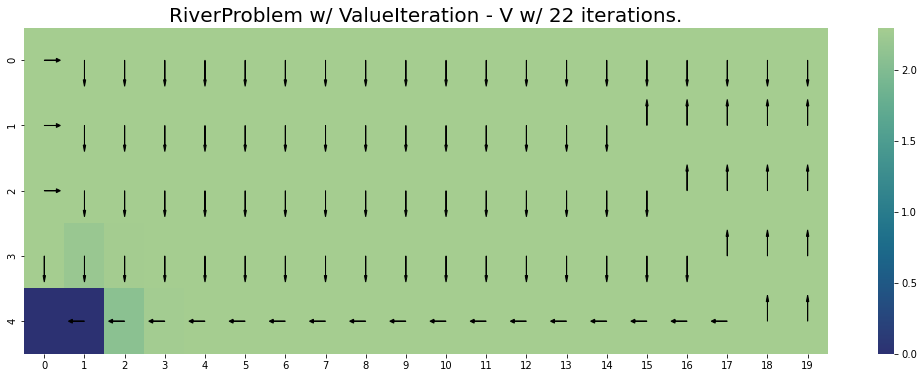

> Visualização da Política 
k: -0.9 
alpha: 0.95 
gamma: 1 

In [5]:
RSPI[(0.5, -0.9, 1, 0.95)]

# Comparando Políticas Geradas

### PieceLinear - RSPI (Risk Sensitive Policy Iteration)

In [ ]:
def build_res_dataframe_RSPI(d, c, nm_file, model):
    res = pd.DataFrame(d.items(), columns=c)
    res.insert(0, 'Model', model)
    res.insert(2, 'RiverFlow', [v[0] for v in res['Keys']])
    res.insert(3, 'K', [v[1] for v in res['Keys']])
    res.insert(4, 'Alpha', [v[2] for v in res['Keys']])
    res.insert(5, 'Gamma', [v[3] for v in res['Keys']])
    
    res.to_excel(os.path.join('saidas', nm_file))
    
    return res

In [7]:
# --------------------------------------------------------------------------------
# Gerando simulações para PieceLinear - RSPI (Risk Sensitive Policy Iteration) ---
# --------------------------------------------------------------------------------

nm_model = 'LINEAR_RSPI'
total_simulations = 10000
average_costs, std_costs, dict_costs = {}, {}, {}

for key in RSPI.keys():
    print(f'Processando [{key}]', end='\r')
    ac = AverageCosts(RSPI[key], costs, give_up=1000)
    res_costs, res_it = ac.run_simulations(total_simulations)
    lst_costs = [c[1] for c in res_costs.items()]
    
    dict_costs[key] = lst_costs
    average_costs[key] = np.mean(lst_costs)
    std_costs[key] = np.std(lst_costs)
    
RSPI_std_costs = build_res_dataframe_RSPI(std_costs, ['Keys', 'Std'], 
                                     nm_file=f'SAIDA_STD_{nm_model}.xlsx', model=nm_model)
RSPI_average_costs = build_res_dataframe_RSPI(average_costs, ['Keys', 'Mean'], 
                                         nm_file=f'SAIDA_MEAN_{nm_model}.xlsx', model=nm_model)

In [25]:
fig = px.line(RSPI_std_costs, x='K', y='Std', color='RiverFlow', title='Standard Deviation for each' + \
                                                                     'value of K in different River Flows')
fig.show()

fig = px.line(RSPI_average_costs, x='K', y='Mean', color='RiverFlow', title='Mean for each' + \
                                                                     'value of K in different River Flows')
fig.show()

### RS-MDP with Exponential Utility Function

In [47]:
def build_res_dataframe_RSMDP(d, c, nm_file, model):
    res = pd.DataFrame(d.items(), columns=c)
    res.insert(0, 'Model', model)
    res.insert(2, 'RiverFlow', [v[0] for v in res['Keys']])
    res.insert(3, 'Lambda', [v[1] for v in res['Keys']])
    res.insert(4, 'DiscountFactor', [v[2] for v in res['Keys']])
    
    res.to_excel(os.path.join('saidas', nm_file))
    
    return res

In [80]:
# --------------------------------------------------------------------
# Gerando simulações para RS-MDP with Exponential Utility Function ---
# --------------------------------------------------------------------

nm_model = 'EXP-UTILITY_RSMDP'
total_simulations = 10000
average_costs, std_costs, dict_costs = {}, {}, {}

for key in RSMDP.keys():
    print(f'Processando [{key}]', end='\r')
    ac = AverageCosts(RSMDP[key], costs, give_up=1000)
    res_costs, res_it = ac.run_simulations(total_simulations)
    lst_costs = [c[1] for c in res_costs.items()]
    
    dict_costs[key] = lst_costs
    average_costs[key] = np.mean(lst_costs)
    std_costs[key] = np.std(lst_costs)
    
RSMDP_std_costs = build_res_dataframe_RSMDP(std_costs, ['Keys', 'Std'], 
                                      nm_file=f'SAIDA_STD_{nm_model}.xlsx', model=nm_model)\
                                      .sort_values(by=['RiverFlow', 'Lambda'])
RSMDP_average_costs = build_res_dataframe_RSMDP(average_costs, ['Keys', 'Mean'], 
                                          nm_file=f'SAIDA_MEAN_{nm_model}.xlsx', model=nm_model)\
                                      .sort_values(by=['RiverFlow', 'Lambda'])

In [86]:
RSMDP_std_costs['Lambda_STR'] = [str(l) for l in RSMDP_std_costs['Lambda']]
RSMDP_average_costs['Lambda_STR'] = [str(l) for l in RSMDP_average_costs['Lambda']]

In [87]:
fig = px.line(RSMDP_std_costs, x='Lambda_STR', y='Std', color='RiverFlow', title='Standard Deviation for each' + \
                                                                     'value of K in different River Flows')
fig.show()

fig = px.line(RSMDP_average_costs, x='Lambda_STR', y='Mean', color='RiverFlow', title='Mean for each' + \
                                                                     'value of K in different River Flows')
fig.show()

# Outras Análises

In [28]:
fig = px.scatter(RSPI_std_costs, x='K', y='Std', color='RiverFlow')
fig.show()

(0.9, 0.5, 1, 0.95)


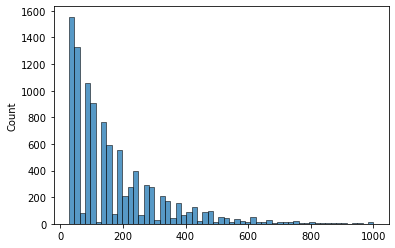

In [38]:
print(list(dict_costs.keys())[-6])
p = sns.histplot(dict_costs[(0.9, 0.5, 1, 0.95)])